In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from torchvision import datasets, transforms
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import glob
import random
import cv2
import imutils
from skimage import color
from skimage.util.dtype import convert
import import_ipynb #pip install import-ipynb
from data import ImageNet
from CUnet import CUNet
from eccv16 import eccv16

from tqdm import tqdm

## Define models and data loaders and hyper-params

In [61]:
cu_model = CUNet()
ecc_model = eccv16()

In [127]:
EPOCHS = 500
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(cu_model.parameters(), lr=0.00001) #change as needed
optimizerSGD = torch.optim.SGD(cu_model.parameters(), lr=0.001) #change as needed
loss_function = torch.nn.MSELoss() #change as needed

In [97]:
cu_model = cu_model.to(device)
ecc_model = ecc_model.to(device)

In [116]:
trans = transforms.Compose([transforms.ToTensor()])
ImageNet_train_dataset = ImageNet(root="./Humans",ext='.JPG', transform=trans, size=200)
ImageNet_eval_dataset = ImageNet(root="./Humans", ext='.PNG',transform=trans)

In [117]:
print(len(ImageNet_train_dataset))
print(len(ImageNet_eval_dataset))

200
150


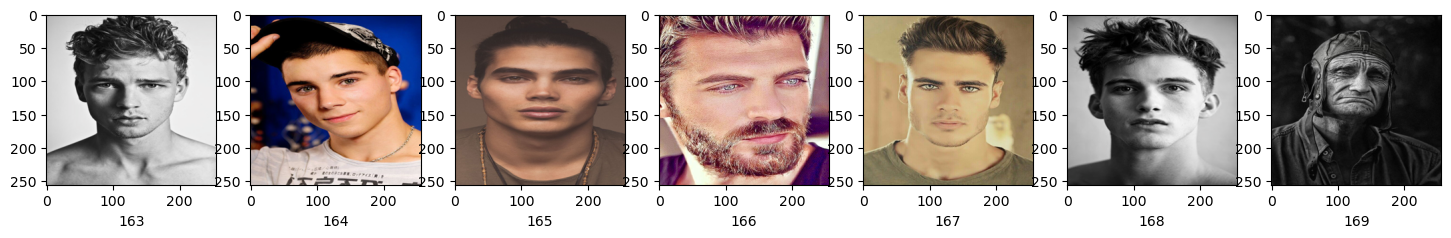

In [118]:
ImageNet_train_dataset.print_samples()

In [119]:
train_dataloader_imagenet = DataLoader(ImageNet_train_dataset, batch_size=20, shuffle=True)
eval_dataloader_imagenet = DataLoader(ImageNet_eval_dataset, batch_size=20, shuffle=True)

## Define Hyper params

## Define Train and eval functions

In [120]:
def train_model(dataloader, model, device, optimizer, loss_function, epochs=1, epoch_offset=0):
    for epoch in range(epoch_offset+1, epochs+epoch_offset+1):
        model.train()
        train_loss = 0
        batchloop = tqdm(enumerate(dataloader), total=len(dataloader))
        for batch_index,(inputs, expected) in batchloop:
            optimizer.zero_grad() 
            inputs = inputs.to(device)
            expected = expected.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, expected)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*len(expected)
            batchloop.set_description(f'Batch[{batch_index}/{len(dataloader)}]')
            batchloop.set_postfix(loss = train_loss)
        print("Epoch",epoch,"Done")
        if epoch%10==0:
            filename = f'model/{type(model).__name__}_{epoch}_{train_loss}.pth'
            torch.save(model.state_dict(), filename)

In [121]:
# Needs to be fixed, has to calculate accuracy and print loss
def eval_model(dataloader, model, device, loss_function):
    model.eval()
    val_loss = 0
    for batch_index,(inputs, expected) in enumerate(dataloader):
        # inputs = torchvision.transforms.ToTensor(train_dataloader_imagenet.resize_image(lightness))
        # expected = torchvision.transforms.ToTensor(train_dataloader_imagenet.resize_image(colors))
        # inputs.type(torch.float32)
        # expected.type(torch.float32)
        print(type(inputs))
        inputs = inputs.to(device)
        expected = expected.to(device)
        outputs = model(inputs)
        loss = loss_function(outputs, expected)
        val_loss += loss.item()*len(expected)
    avg_val_loss = val_loss/len(eval_dataloader_imagenet)
    print("Eval Loss")

In [122]:
def print_comparisons(start,model):
    for i in range(start,start+5):
        org1, pred1 = ImageNet_eval_dataset.check_output(i,model)
        org1_resize = Image.fromarray((org1 * 255).astype(np.uint8)).resize((256,256)) # get resize image 
        
        figure, axes = plt.subplots(1, 2, figsize=(18,10))
        axes = axes.flatten()
        axes[0].imshow(org1_resize) # show resized image instead of original size image
        axes[1].imshow(pred1)

In [123]:
def name_to_epoch(name):
    _, epoch, _ = name.split("_") #name, epoch, avg_l.pth
    return(int(epoch))

In [124]:
def get_latest_weights(model):
    paths = glob.glob(f'model/{type(model).__name__}_*.pth')
    #only find models that have the same type as the model being trained
    
    paths.sort(key = name_to_epoch) #most recent epoch
    start = -1
    if len(paths) > 0:
        target = paths[-1]
        start = name_to_epoch(target)
        model.load_state_dict(torch.load(target))
    return start

### Train Models

In [128]:
start = get_latest_weights(cu_model)
train_model(train_dataloader_imagenet, cu_model, device, optimizer, loss_function, 200, start)

Batch[9/10]: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it, loss=1.09e+3]


Epoch 551 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it, loss=1.09e+3]


Epoch 552 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it, loss=1.06e+3]


Epoch 553 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it, loss=1.08e+3]


Epoch 554 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it, loss=967]


Epoch 555 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it, loss=931]


Epoch 556 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it, loss=1.12e+3]


Epoch 557 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it, loss=1.07e+3]


Epoch 558 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it, loss=948]


Epoch 559 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it, loss=1.02e+3]


Epoch 560 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it, loss=1.25e+3]


Epoch 561 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it, loss=898]


Epoch 562 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it, loss=1.17e+3]


Epoch 563 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it, loss=1.03e+3]


Epoch 564 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it, loss=946]


Epoch 565 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it, loss=1.02e+3]


Epoch 566 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it, loss=1.1e+3]


Epoch 567 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it, loss=1.28e+3]


Epoch 568 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it, loss=1.05e+3]


Epoch 569 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it, loss=909]


Epoch 570 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it, loss=1.08e+3]


Epoch 571 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it, loss=1.29e+3]


Epoch 572 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it, loss=1.24e+3]


Epoch 573 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it, loss=1.02e+3]


Epoch 574 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it, loss=1.07e+3]


Epoch 575 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it, loss=1.17e+3]


Epoch 576 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it, loss=1.06e+3]


Epoch 577 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it, loss=1.13e+3]


Epoch 578 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it, loss=1.12e+3]


Epoch 579 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it, loss=1.04e+3]


Epoch 580 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it, loss=1.06e+3]


Epoch 581 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it, loss=1.11e+3]


Epoch 582 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it, loss=1.13e+3]


Epoch 583 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it, loss=1.07e+3]


Epoch 584 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it, loss=1.06e+3]


Epoch 585 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it, loss=1.19e+3]


Epoch 586 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it, loss=1.02e+3]


Epoch 587 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it, loss=926]


Epoch 588 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it, loss=1.22e+3]


Epoch 589 Done


Batch[9/10]: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it, loss=904]


Epoch 590 Done


Batch[9/10]: 100%|██████████| 10/10 [00:13<00:00,  1.36s/it, loss=1.02e+3]


Epoch 591 Done


Batch[9/10]: 100%|██████████| 10/10 [00:13<00:00,  1.37s/it, loss=1.1e+3]


Epoch 592 Done


Batch[3/10]:  40%|████      | 4/10 [00:06<00:10,  1.71s/it, loss=521]


KeyboardInterrupt: 

In [ ]:
start = get_latest_weights(ecc_model)
train_model(train_dataloader_imagenet, ecc_model, device, optimizer, loss_function, EPOCHS, start)

### Eval Models

In [ ]:
# eval_model(eval_dataloader_imagenet, cu_model, device, loss_function)

In [ ]:
# eval_model(eval_dataloader_imagenet, ecc_model, device, loss_function)

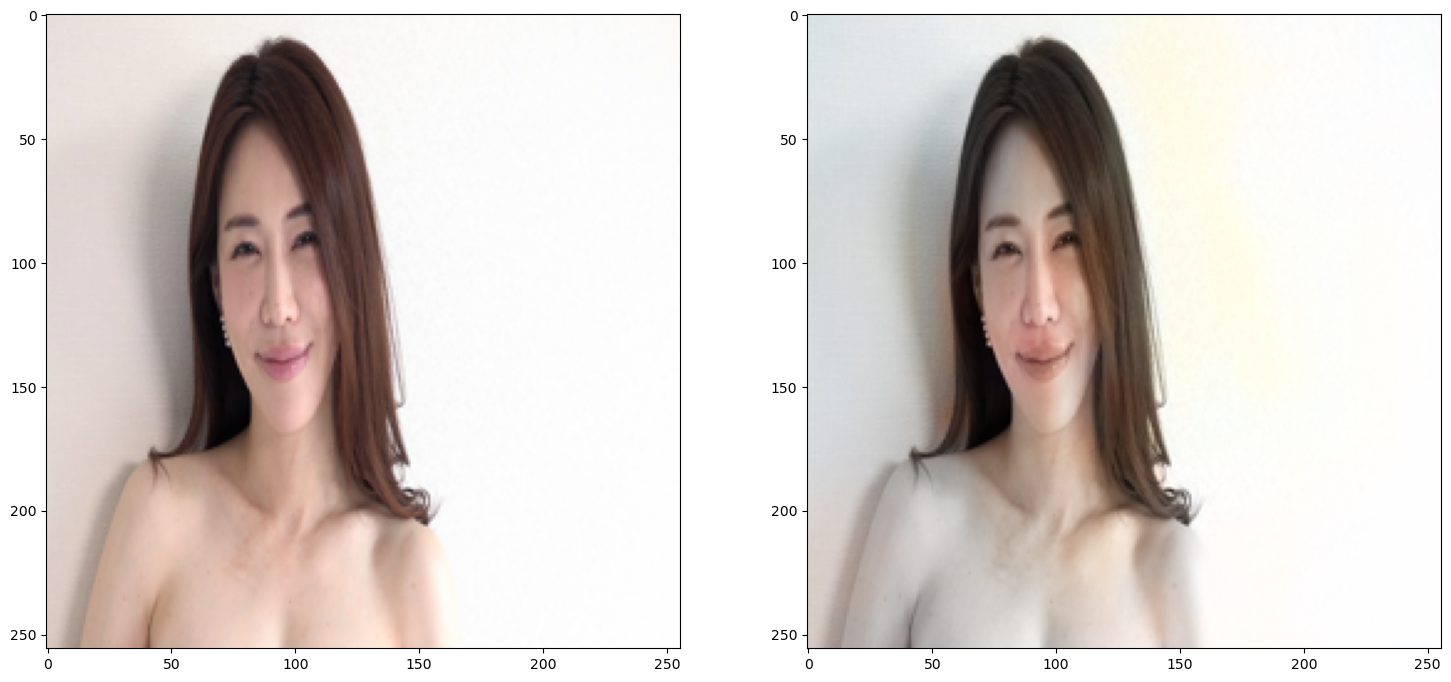

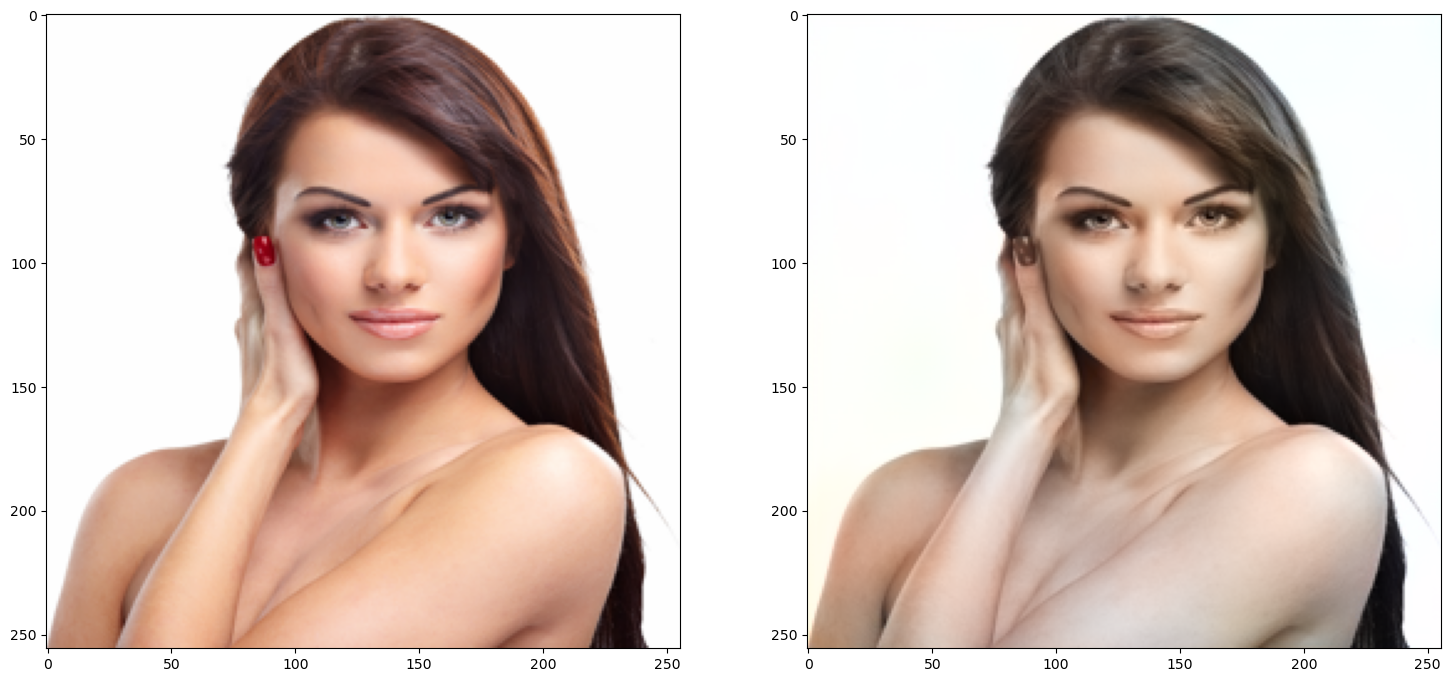

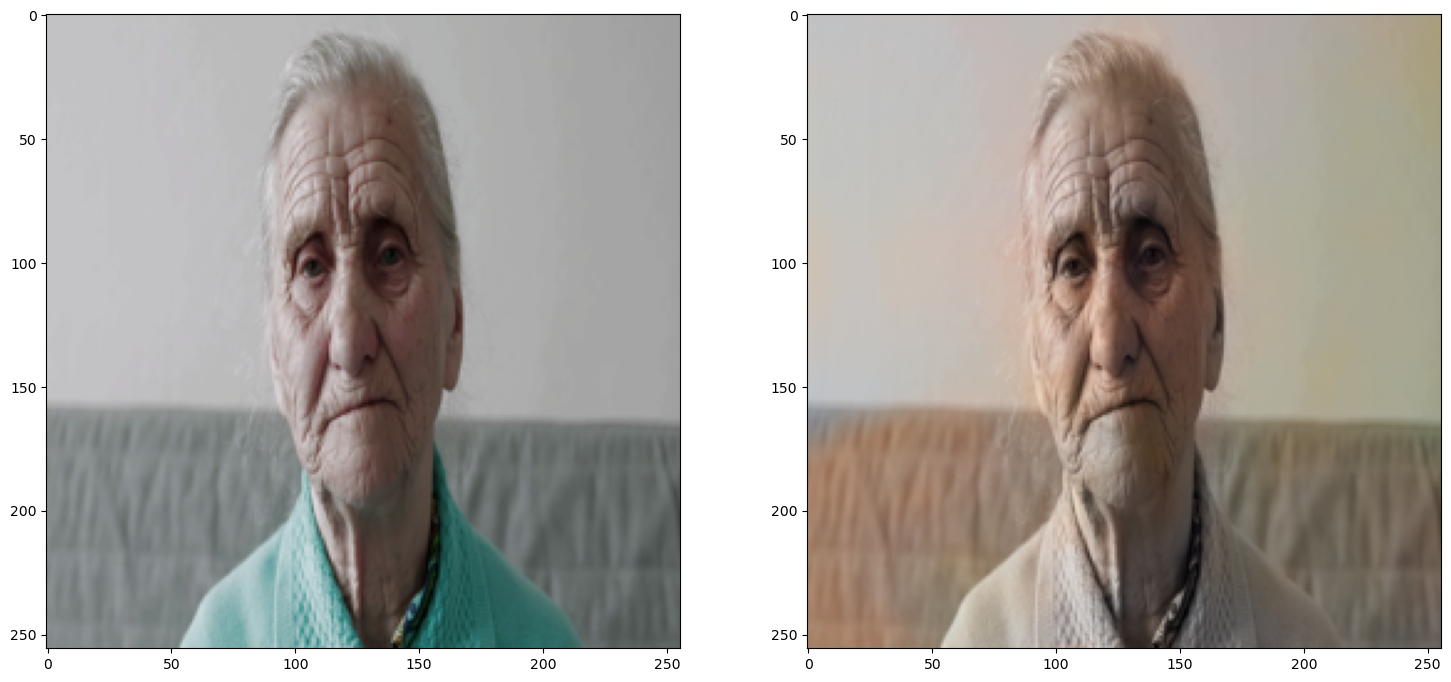

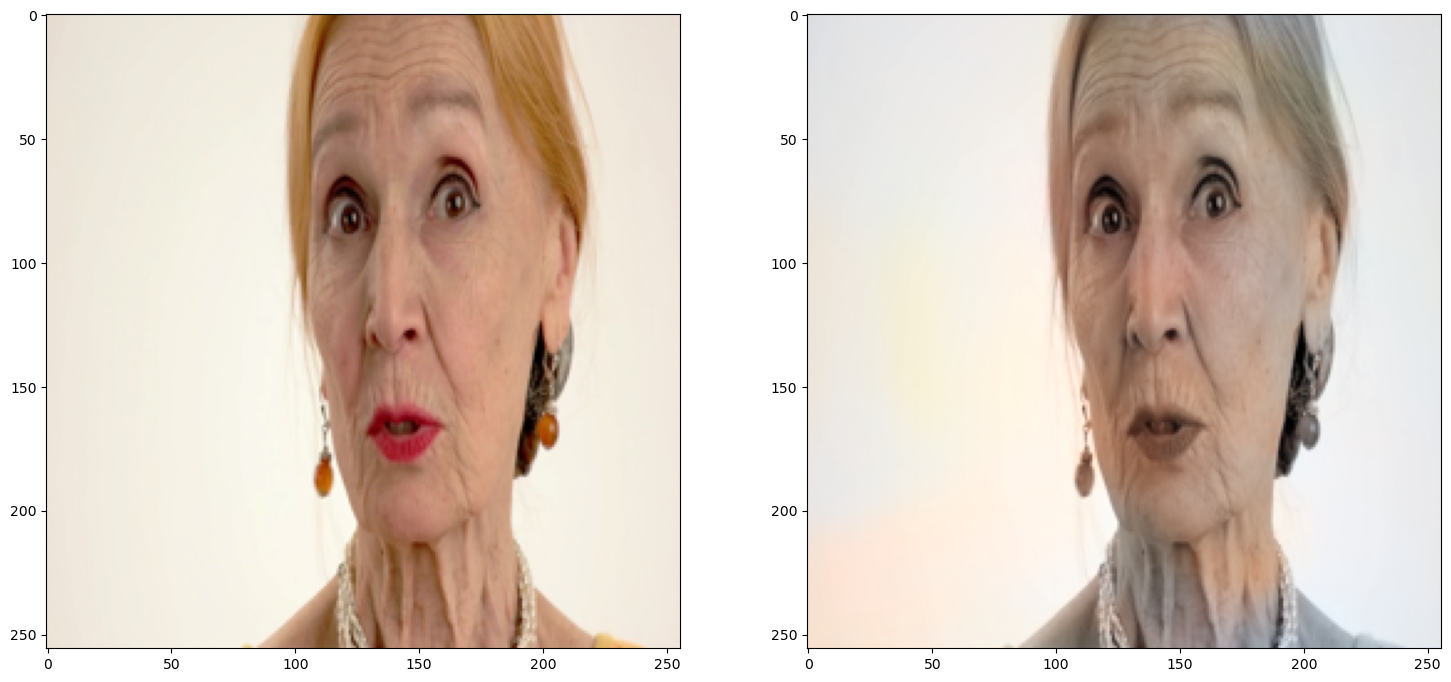

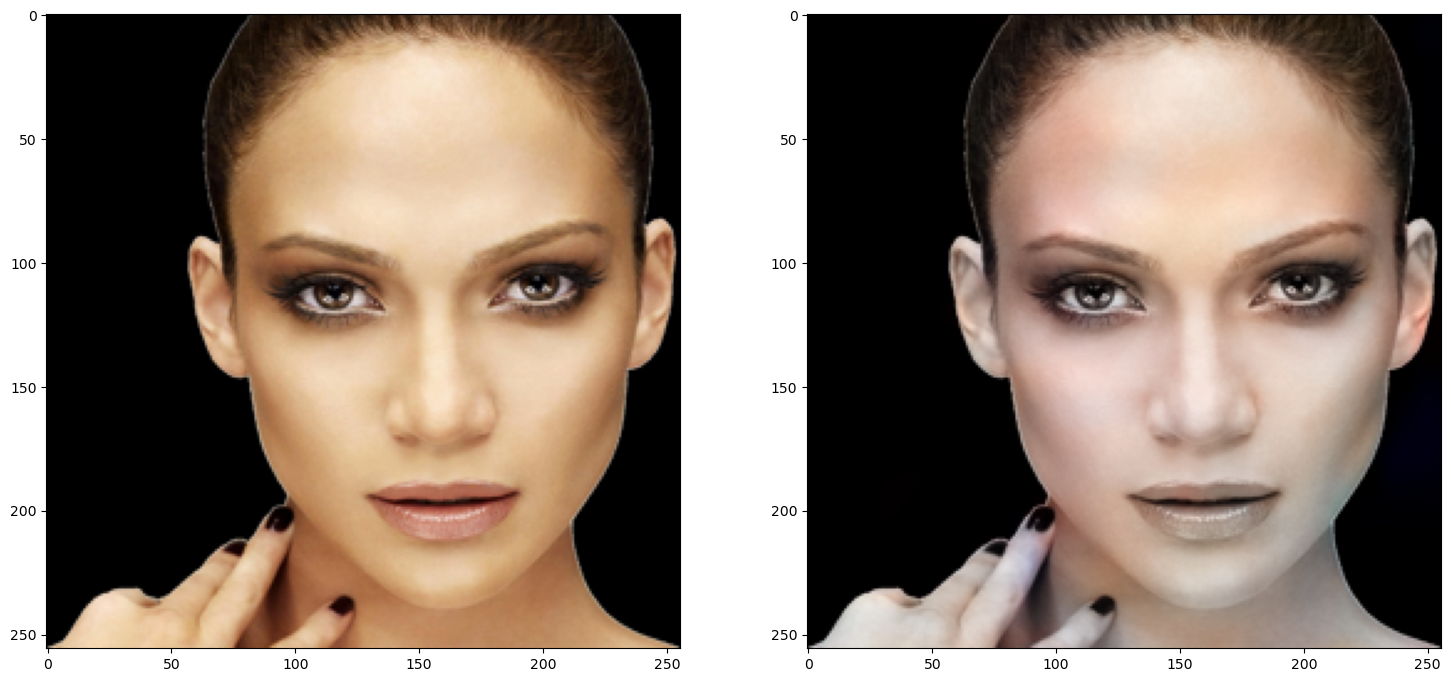

In [135]:
temp = get_latest_weights(cu_model)
print_comparisons(140,cu_model)